In [43]:
#Graph Gen 1.1 (27/03/2025)
# Added inputs and outputs
# The power consumption for a node ranges from 1 to 50 units and uniformly distributed.
# Plus the area may vary from 1 to 5 units as well, uniformly distributed
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import random

def generate_netlist(
    num_nodes=50,
    num_edges=100,
    enable_area=True,
    #Area (chip constraints) of the node or the gate assembly
    enable_power=True,
    # Power consumption of the gate (used to optimize or reduce heat generation or power consumption per chip)
    enable_wire_count=True,
    # Number of wires represented by an edge
    enable_distance=True,
    # Distance of the wire to calculate power dissipation and delay
    seed = None
):
    """Generates a netlist as a graph with configurable node & edge attributes."""
    if seed:
        random.seed(seed)
        np.random.seed(seed)

    #Generate a directed graph
    G = nx.DiGraph()

    # Estimate number of inputs and outputs
    # Assuming num_inputs and num_outputs to be the functions below
    num_inputs = math.ceil(math.log2(num_nodes))
    num_outputs = math.ceil(num_inputs / 2)
    input_nodes = [f"IN_{i}" for i in range(num_inputs)]
    output_nodes = [f"OUT_{i}" for i in range(num_outputs)]


    # Create internal nodes
    for i in range(num_nodes):
        node_name = f"N_{i}"
        G.add_node(node_name)

        if enable_area:
            G.nodes[node_name]['area'] = round(random.uniform(1.0, 5.0), 2)
        if enable_power:
            G.nodes[node_name]['power'] = round(random.uniform(1.0, 50.0), 2)

    # Create input and output nodes
    for node in input_nodes + output_nodes:
        G.add_node(node)

    # Ensure the graph is connected using a spanning tree first
    all_nodes = input_nodes + [f"N_{i}" for i in range(num_nodes)]
    random.shuffle(all_nodes)
    for i in range(len(all_nodes) - 1):
        G.add_edge(all_nodes[i], all_nodes[i + 1])
        if enable_wire_count:
            G.edges[all_nodes[i], all_nodes[i + 1]]['wires'] = random.randint(1, 5)
        if enable_distance:
            G.edges[all_nodes[i], all_nodes[i + 1]]['distance'] = round(random.uniform(1.0, 10.0), 2)

    # Add additional random edges while keeping the graph connected
    existing_edges = set(G.edges())
    while len(G.edges()) < num_edges:
        u, v = random.sample(all_nodes, 2)
        if u != v and (u, v) not in existing_edges:
            G.add_edge(u, v)
            existing_edges.add((u, v))
            if enable_wire_count:
                G.edges[u, v]['wires'] = random.randint(1, 5)
            if enable_distance:
                G.edges[u, v]['distance'] = round(random.uniform(1.0, 10.0), 2)

    # Ensure each output node has at least one incoming connection
    for out_node in output_nodes:
        if G.in_degree(out_node) == 0:
            source_node = random.choice(all_nodes)
            G.add_edge(source_node, out_node)
            if enable_wire_count:
                G.edges[source_node, out_node]['wires'] = random.randint(1, 5)
            if enable_distance:
                G.edges[source_node, out_node]['distance'] = round(random.uniform(1.0, 10.0), 2)

    return G, input_nodes, output_nodes

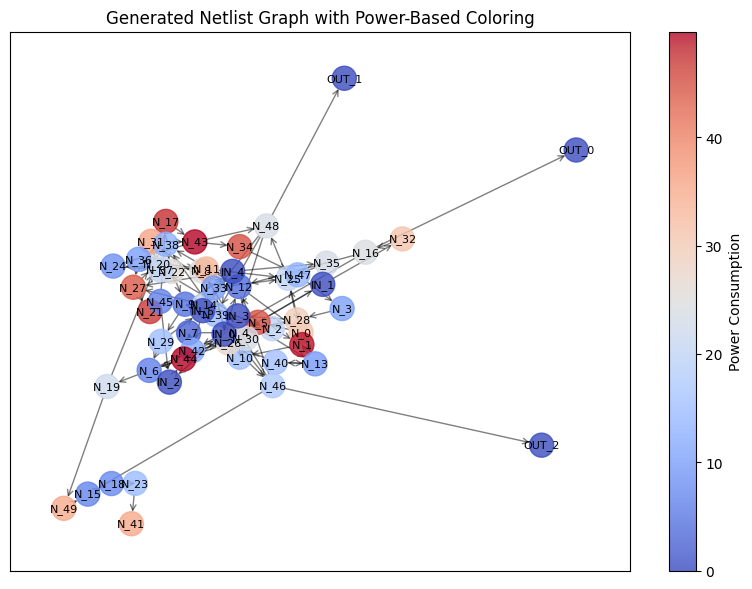

In [44]:
def visualize_netlist(G):
    pos = nx.spring_layout(G, seed=42)
    power_values = [G.nodes[n].get('power', 0) for n in G.nodes()]

    plt.figure(figsize=(10, 7))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=power_values, cmap='coolwarm', alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.5, arrowstyle='->', arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)

    cbar = plt.colorbar(nodes)
    cbar.set_label("Power Consumption")
    plt.title("Generated Netlist Graph with Power-Based Coloring")
    plt.show()

# Example usage
graph, inputs, outputs = generate_netlist(num_nodes=50, num_edges=100)
visualize_netlist(graph)


In [45]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np

def calculate_critical_path(G, cluster_labels):
    """Calculate the critical path length considering inter-cluster wire delays"""
    # Build a new graph where inter-cluster edges have 10x distance
    extended_G = nx.DiGraph()

    for u, v, data in G.edges(data=True):
        if cluster_labels[u] != cluster_labels[v]:
            # Inter-cluster edge - 10x distance
            extended_G.add_edge(u, v, distance=data.get('distance', 1.0) * 10)
        else:
            # Intra-cluster edge - normal distance
            extended_G.add_edge(u, v, distance=data.get('distance', 1.0))

    # Find all paths from inputs to outputs and calculate their total distance
    input_nodes = [n for n in G.nodes() if n.startswith('IN_')]
    output_nodes = [n for n in G.nodes() if n.startswith('OUT_')]

    max_path_length = 0
    critical_path = []

    for input_node in input_nodes:
        for output_node in output_nodes:
            if nx.has_path(extended_G, input_node, output_node):
                path_length = 0
                path = nx.shortest_path(extended_G, input_node, output_node, weight='distance')
                for i in range(len(path)-1):
                    path_length += extended_G[path[i]][path[i+1]]['distance']

                if path_length > max_path_length:
                    max_path_length = path_length
                    critical_path = path

    return max_path_length, critical_path

In [46]:
def agglomerative_clustering_netlist(G, n_clusters=3):
    """Perform agglomerative clustering on the netlist with custom metrics"""
    # Extract node positions (from visualization) for distance metric
    pos = nx.spring_layout(G, seed=42)
    node_names = list(G.nodes())
    node_coords = np.array([pos[node] for node in node_names])

    # Perform clustering based on positions (minimize wire length)
    clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    linkage='ward'
    )
    cluster_labels = clustering.fit_predict(node_coords)

    # Create a dictionary of node to cluster mapping
    node_clusters = {node: label for node, label in zip(node_names, cluster_labels)}

    # Calculate metrics
    total_cut_size = 0
    total_wire_length = 0
    total_power = [0] * n_clusters
    total_area = [0] * n_clusters

    # Calculate cluster statistics
    for node in G.nodes():
        cluster = node_clusters[node]
        if 'power' in G.nodes[node]:
            total_power[cluster] += G.nodes[node]['power']
        if 'area' in G.nodes[node]:
            total_area[cluster] += G.nodes[node]['area']

    # Calculate cut size and wire length
    for u, v, data in G.edges(data=True):
        wire_length = data.get('distance', 1.0)
        wires = data.get('wires', 1)

        if node_clusters[u] != node_clusters[v]:
            # Inter-cluster edge
            total_cut_size += wires
            total_wire_length += wire_length * 10 * wires
        else:
            # Intra-cluster edge
            total_wire_length += wire_length * wires

    # Calculate critical path
    critical_path_length, critical_path = calculate_critical_path(G, node_clusters)

    return {
        'node_clusters': node_clusters,
        'total_cut_size': total_cut_size,
        'total_wire_length': total_wire_length,
        'cluster_power': total_power,
        'cluster_area': total_area,
        'critical_path_length': critical_path_length,
        'critical_path': critical_path
    }

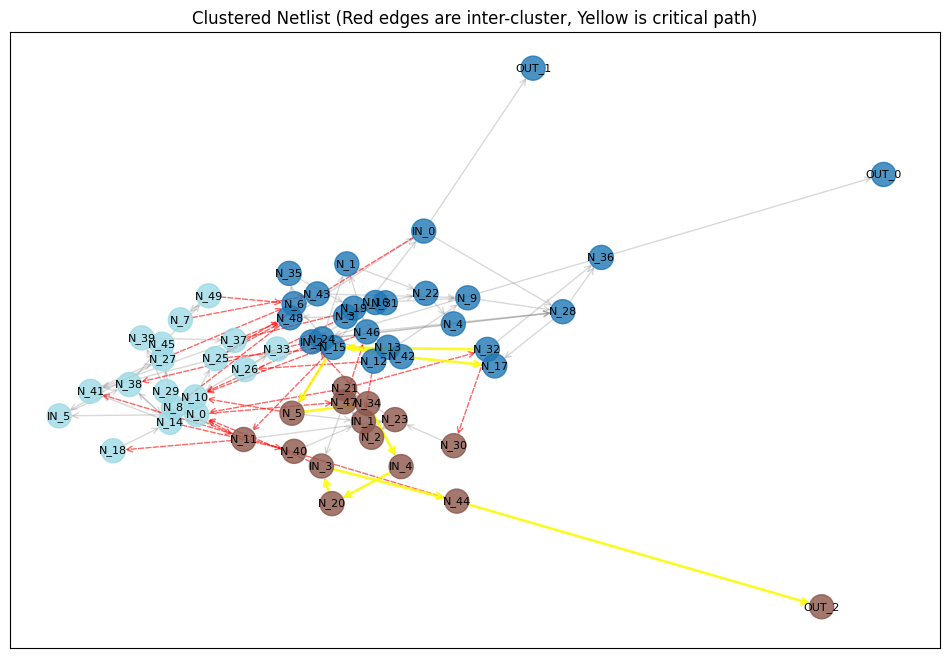


Clustering Metrics:
Total cut size: 80
Total wire length (with 10x penalty for inter-cluster): 5350.95
Critical path length: 131.07

Cluster Power Distribution:
Cluster 0: 587.23
Cluster 1: 364.09
Cluster 2: 495.81

Cluster Area Distribution:
Cluster 0: 59.70
Cluster 1: 32.83
Cluster 2: 53.19


In [47]:
def visualize_clustered_netlist(G, clustering_result):
    """Visualize the netlist with cluster coloring"""
    pos = nx.spring_layout(G, seed=42)
    node_clusters = clustering_result['node_clusters']
    cluster_labels = [node_clusters[node] for node in G.nodes()]

    plt.figure(figsize=(12, 8))

    # Draw nodes with cluster coloring
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=cluster_labels,
        cmap='tab20',
        alpha=0.8
    )

    # Draw edges with different styles for inter-cluster edges
    for u, v in G.edges():
        if node_clusters[u] == node_clusters[v]:
            # Intra-cluster edge
            nx.draw_networkx_edges(
                G, pos,
                edgelist=[(u, v)],
                alpha=0.3,
                edge_color='gray',
                arrowstyle='->',
                arrows=True
            )
        else:
            # Inter-cluster edge
            nx.draw_networkx_edges(
                G, pos,
                edgelist=[(u, v)],
                alpha=0.6,
                edge_color='red',
                style='dashed',
                arrowstyle='->',
                arrows=True
            )

    # Highlight critical path
    if clustering_result['critical_path']:
        path_edges = list(zip(clustering_result['critical_path'], clustering_result['critical_path'][1:]))
        nx.draw_networkx_edges(
            G, pos,
            edgelist=path_edges,
            edge_color='yellow',
            width=2,
            alpha=0.8,
            arrowstyle='->',
            arrows=True
        )

    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title("Clustered Netlist (Red edges are inter-cluster, Yellow is critical path)")
    plt.show()

    # Print metrics
    print("\nClustering Metrics:")
    print(f"Total cut size: {clustering_result['total_cut_size']}")
    print(f"Total wire length (with 10x penalty for inter-cluster): {clustering_result['total_wire_length']:.2f}")
    print(f"Critical path length: {clustering_result['critical_path_length']:.2f}")
    print("\nCluster Power Distribution:")
    for i, power in enumerate(clustering_result['cluster_power']):
        print(f"Cluster {i}: {power:.2f}")
    print("\nCluster Area Distribution:")
    for i, area in enumerate(clustering_result['cluster_area']):
        print(f"Cluster {i}: {area:.2f}")

# Example usage
graph, inputs, outputs = generate_netlist(num_nodes=50, num_edges=100)
clustering_result = agglomerative_clustering_netlist(graph, n_clusters=3)
visualize_clustered_netlist(graph, clustering_result)